In [3]:
import glob
import os
import random
import sys

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

In [4]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path='/content/drive'
  base_folder = "/Data/FX"
  data_folder = f'{mount_path}/My Drive{base_folder}'
  drive.mount(mount_path)
else:
  base_folder = '../../Data/'
  data_folder = os.path.join(base_folder, "fx")

colors = [*mcolors.TABLEAU_COLORS.values()]

In [3]:
def read_oanda_tickdata(path):
    df = pd.read_csv(path, sep="\t")
    date_index = pd.DatetimeIndex(df["<DATE>"] +"T"+ df["<TIME>"])
    price = df["<BID>"]
    spread = df["<ASK>"] - price
    tick_df = pd.concat([price, spread], axis=1, keys=["price", "spread"])
    tick_df.set_index(date_index, inplace=True)
    return tick_df

def search_tick_files(sub_folder, pair, year):
    return glob.glob(os.path.join(data_folder, sub_folder, pair, f"ticks_USDJPY-oj5k_{year}-*.zip"))

def merge_ticks(files):
    DFS = []

    for file in files:
        DFS.append(read_oanda_tickdata(file))
    tick_df = pd.concat(DFS, axis=0)
    tick_df.sort_index(inplace=True)
    return tick_df

files = search_tick_files(sub_folder="OANDA-Japan TicksDL", pair="USDJPY", year=2021)
tick_df = merge_ticks(files)

In [5]:
ohlc_column = ['open','high','low','close']
file_name = f"OANDA-Japan MT5 Live/mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


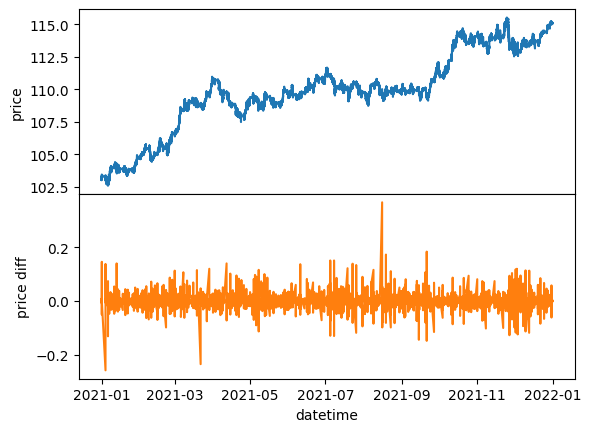

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(tick_df["price"], color=colors[0])
ax2.plot(tick_df["price"].diff(), color=colors[1])

ax1.set_ylabel('price')
ax2.set_xlabel('datetime')
ax2.set_ylabel('price diff')
plt.subplots_adjust(hspace=0)

plt.show()

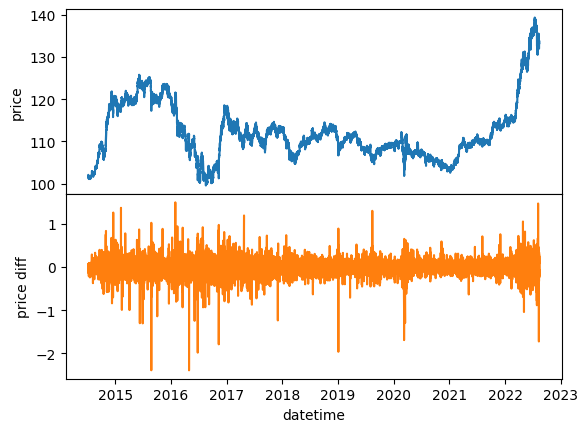

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df["close"], color=colors[0])
ax2.plot(df["close"].diff(), color=colors[1])

ax1.set_ylabel('price')
ax2.set_xlabel('datetime')
ax2.set_ylabel('price diff')
plt.subplots_adjust(hspace=0)

plt.show()

## Price difference

In [47]:
def laplace_dist(x, mean, std):
    return   (1 / (np.sqrt(2) * std)) * np.exp(- (np.sqrt(2)* abs(x - mean))/std)

In [48]:
def normal_dist(x, mean, std):
    return (1/(std * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std**2)))

In [257]:
mean = df["close"].diff().mean()
std = df["close"].diff().std()

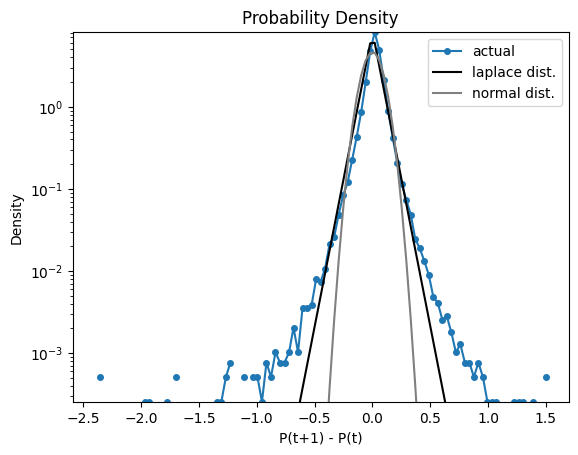

In [260]:
counts, bin_edges = np.histogram(df["close"].diff().iloc[1:], bins=100, density=True)
counts[counts == 0] = np.NaN
laplace = [laplace_dist(value, mean, std) for value in bin_edges]
normal = [normal_dist(value, mean, std) for value in bin_edges]
plt.plot(bin_edges[1:], counts, color=colors[0], marker="o", markersize=4, label="actual")
plt.plot(bin_edges, laplace, color="black", label="laplace dist.")
plt.plot(bin_edges, normal, color="gray", label="normal dist.")
plt.yscale('log')
plt.title('Probability Density')
plt.xlabel('P(t+1) - P(t)')
plt.ylabel('Density')
plt.ylim(min(counts), max(counts))
plt.legend()
plt.show()

In [135]:
def cumulative_dist(data, bins=100):
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts_prob = counts/counts.sum()
    cumulative = np.cumsum(counts_prob)
    possibilities = 1 - cumulative
    return np.array([1, *possibilities]) , np.array([1e-10, *bin_edges[1:]])

In [262]:
mean = tick_df["price"].diff().mean()
std = tick_df["price"].diff().std()

cumulative, bin_edges = cumulative_dist(tick_df.diff().abs().iloc[1:], bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
n_cumulative, n_bin_edges = cumulative_dist(data)

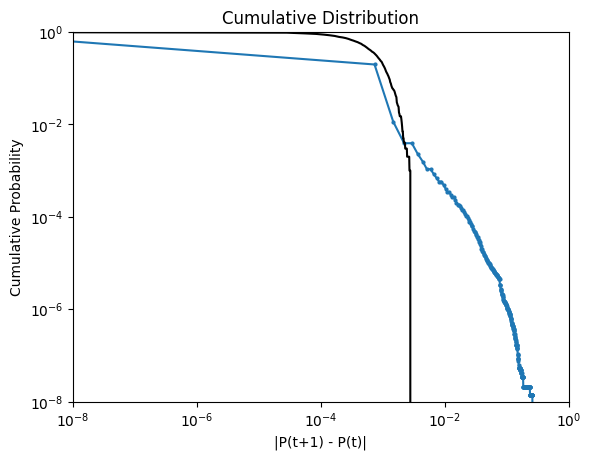

In [266]:
plt.plot(bin_edges, cumulative, color=colors[0], marker="o", markersize=2)
plt.plot(n_bin_edges, n_cumulative, color="black")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1)
plt.xlim(1e-8, 1)
plt.show()

In [268]:
slopes = []
x_left = 1e-3
x_right = 1e-1
target_x_values = bin_edges[(bin_edges >= x_left) & ((bin_edges <= x_right))]
target_y_values = cumulative[(bin_edges >= x_left) & ((bin_edges <= x_right))]

for index in range(0, len(target_y_values) -2):
    slope = np.log(target_y_values[-1]/target_y_values[index])/np.log(target_x_values[-1]/target_x_values[index])
    slopes.append(slope)
slope = np.mean(slopes)
slope

-3.3135264364970123

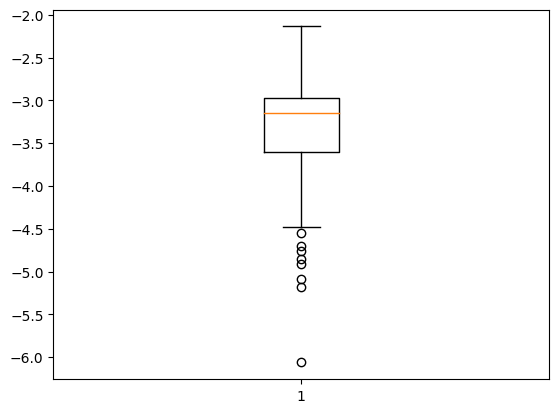

In [251]:
plt.boxplot(slopes)
plt.show()

In [254]:
baseic_slope = -3
indices = [1e-3, 1e-2, 1e-1]

x = 1e-1
y_of_x = 1e+6
a = (x ** slope) * y_of_x
exponent_line = [(1/a) * value ** slope for value in indices]
a = (x ** baseic_slope) * y_of_x
basic_exponent_line = [(1/a) * value ** baseic_slope for value in indices]

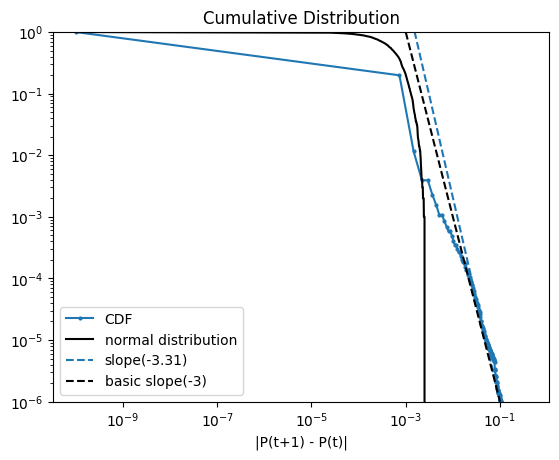

In [256]:
plt.plot(bin_edges, cumulative, color=colors[0], marker="o", markersize=2, label="CDF")
plt.plot(n_bin_edges, n_cumulative, color="black", label="normal distribution")
plt.plot(indices, exponent_line, linestyle="--", color=colors[0], label=f"slope({round(slope, 2)})")
plt.plot(indices, basic_exponent_line, linestyle="--", color="black", label="basic slope(-3)")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-6, 1)
plt.legend()
plt.show()

## Seasonal

In [6]:
TIME_UNIT_MIN = 30
counts_in_day = (60/TIME_UNIT_MIN) * 24

sample_index = 100

week_num = df.index[sample_index].dayofweek * counts_in_day
hour_num = df.index[sample_index].hour * (60/TIME_UNIT_MIN)
min_num = df.index[sample_index].minute / TIME_UNIT_MIN

sample_seasonal_index = week_num + hour_num + min_num
sample_seasonal_index

117.0

In [24]:
def get_seasonal_index(datetime, time_unit_min=None):
    if time_unit_min is None:
        time_unit_min = TIME_UNIT_MIN
    counts_in_day = (60/time_unit_min) * 24
    week_num =datetime.dayofweek * counts_in_day
    hour_num =datetime.hour * (60/time_unit_min)
    min_num =datetime.minute / time_unit_min

    return week_num + hour_num + min_num

### Volume 

<Axes: xlabel='time'>

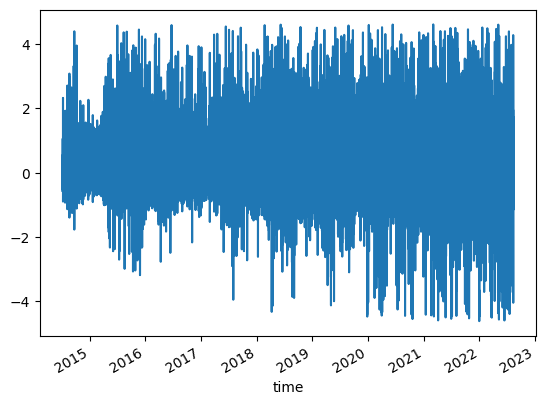

In [182]:
WINDOW = 5

volume_pct = df["tick_volume"].pct_change().dropna()
detrend = (volume_pct - volume_pct.rolling(window=WINDOW).mean()).dropna()
detrend_std = detrend.std()
detrend_common = detrend[detrend.abs() <= detrend_std]
detrend_common.plot()

In [183]:
test_index = get_seasonal_index(detrend_common.index)
test_df = pd.DataFrame.from_dict({"detrend": list(detrend_common), "time_index": list(test_index)})

In [184]:
seasonal_indices = []
counts_in_day = int(counts_in_day)
for i in range(0, counts_in_day*7):
    value = test_df[test_df["time_index"] == i]["detrend"].mean()
    seasonal_indices.append(value)

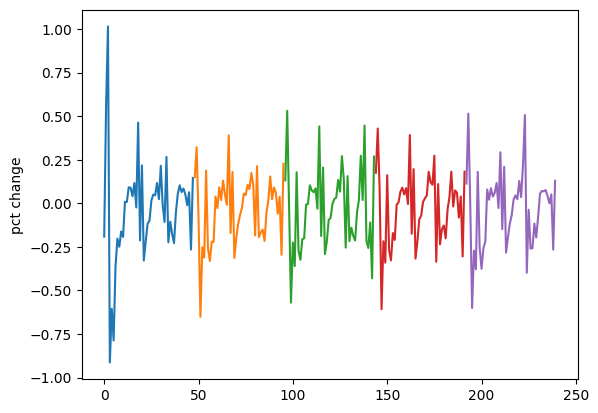

In [185]:
import matplotlib.pyplot as plt


for i in range(0, 7):
    start_index = i*counts_in_day
    end_index = counts_in_day*(i+1)
    indices = list(range(start_index, end_index))
    plt.plot(indices, seasonal_indices[start_index:end_index])
plt.ylabel("pct change")
plt.xlabel("")
plt.show()

In [194]:
import datetime

sample_date = datetime.datetime(2020, 2, 3)
end_date = sample_date + datetime.timedelta(days=7*1)
sample_volume_pct_row = volume_pct[(volume_pct.index >= sample_date) & (volume_pct.index < end_date)]

volume_pct_mean = volume_pct.rolling(window=WINDOW).mean()
sample_volume_pct_mean = volume_pct_mean[(volume_pct_mean.index >= sample_date) & (volume_pct_mean.index < end_date)]

index = [int(index) for index in list(get_seasonal_index(sample_volume_pct_mean.index))]
sample_seasonal_indices = np.array(seasonal_indices)[index]

sample_deseasonal = sample_volume_pct_row - sample_seasonal_indices

sample_residual = sample_volume_pct_row - sample_volume_pct_mean - sample_seasonal_indices

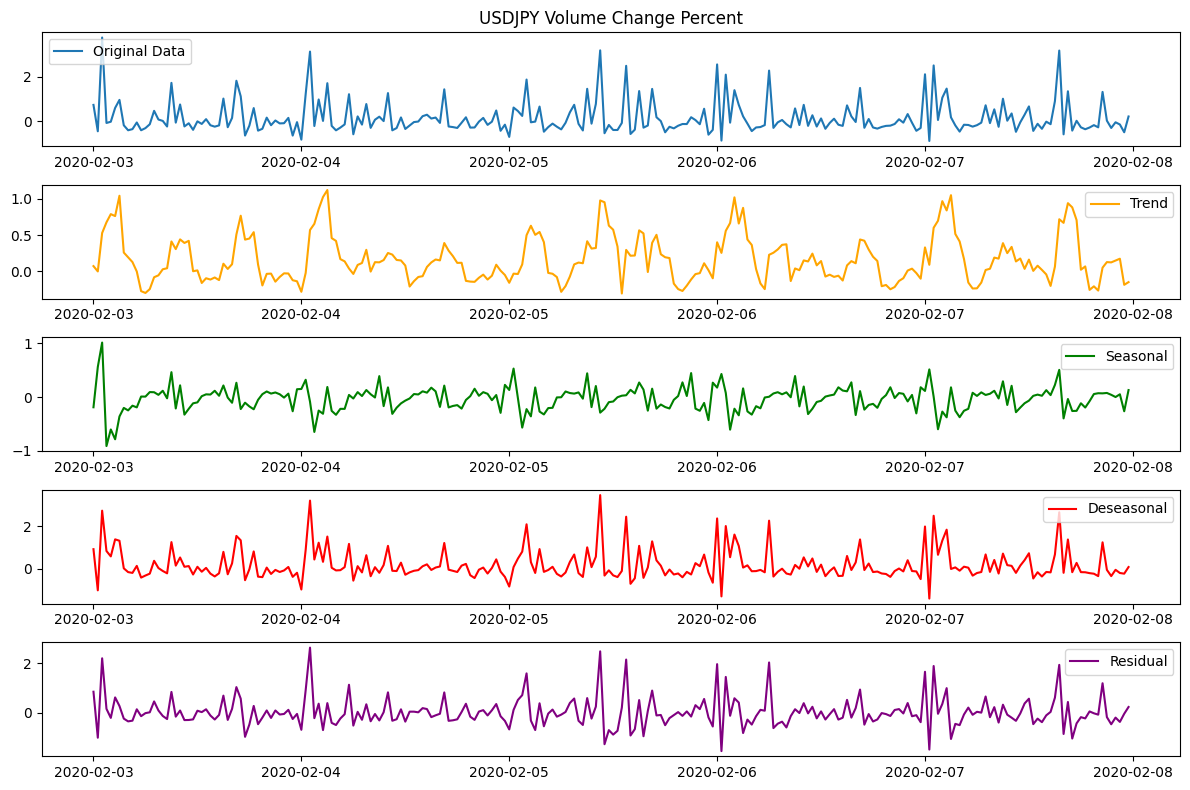

In [195]:
plt.figure(figsize=(12, 8))

plt.subplot(5, 1, 1)
plt.title(f"USDJPY Volume Change Percent")

plt.plot(sample_volume_pct_row.index, sample_volume_pct_row, label="Original Data")
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sample_volume_pct_mean.index,sample_volume_pct_mean, label="Trend", color='orange')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sample_volume_pct_mean.index, sample_seasonal_indices, label="Seasonal", color='green')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sample_volume_pct_row.index, sample_deseasonal, label="Deseasonal", color='red')
plt.legend()


plt.subplot(5, 1, 5)
plt.plot(sample_volume_pct_row.index, sample_residual, label="Residual", color='purple')
plt.legend()

plt.tight_layout()
plt.show()

### Close

<Axes: xlabel='time'>

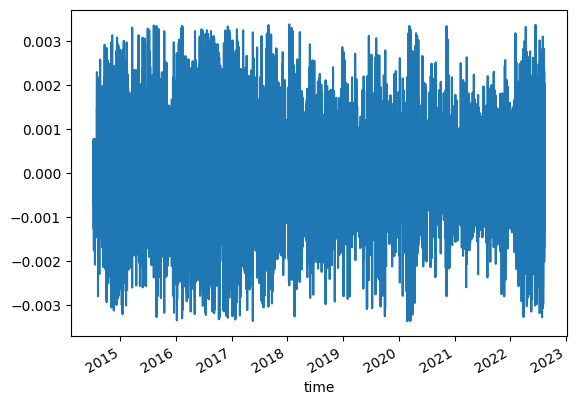

In [19]:
WINDOW = 5
STD_THRETHOLD = 5

close_pct = df["close"].pct_change().dropna()
detrend = (close_pct - close_pct.rolling(window=WINDOW).mean()).dropna()
detrend_std = detrend.std()
detrend_common = detrend[detrend.abs() <= detrend_std*STD_THRETHOLD]
detrend_common.plot()

In [20]:
test_index = get_seasonal_index(detrend_common.index)
test_df = pd.DataFrame.from_dict({"detrend": list(detrend_common), "time_index": list(test_index)})

In [21]:
seasonal_indices = []
counts_in_day = int(counts_in_day)
for i in range(0, counts_in_day*7):
    value = test_df[test_df["time_index"] == i]["detrend"].mean()
    seasonal_indices.append(value)

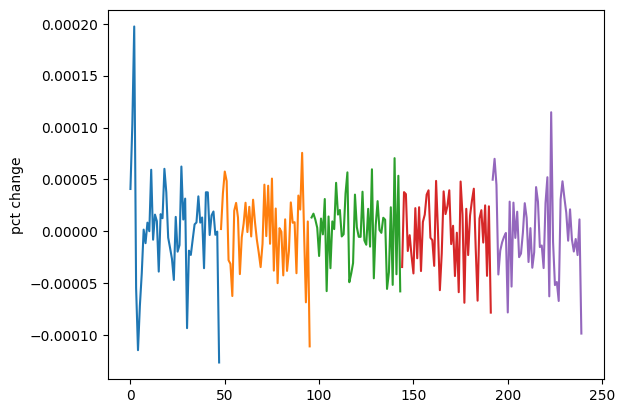

In [22]:
import matplotlib.pyplot as plt


for i in range(0, 7):
    start_index = i*counts_in_day
    end_index = counts_in_day*(i+1)
    indices = list(range(start_index, end_index))
    plt.plot(indices, seasonal_indices[start_index:end_index])
plt.ylabel("pct change")
plt.xlabel("")
plt.show()

## Similarity

In [392]:
def z(price_diff_srs, mean, std):
    return (price_diff_srs - mean)/std

def diff_periods_similarity(price_srs:pd.Series, k=100, k_bias=0):
    base_srs = price_srs.diff(periods=1)
    base_mean = base_srs.mean()
    base_std = base_srs.std()
    base_z = z(base_srs, base_mean, base_std)
    
    similarities = []
    sim_stds = []
    ks = [*range(1+k_bias, 1 + k_bias + k)]
    for period in ks:
        diff_srs = price_srs.diff(periods=period)
        diff_mean = diff_srs.mean()
        diff_std = diff_srs.std()
        perid_z = z(diff_srs, diff_mean, diff_std)
        sim_srs = base_z * perid_z
        sim = sim_srs.mean()
        sim_std = sim_srs.std()
        similarities.append(sim)
        sim_stds.append(sim_std)
    return ks, similarities, sim_stds

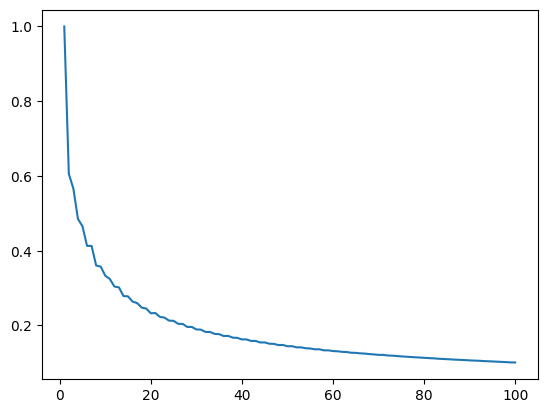

In [388]:
indices, sims, sim_stds = diff_periods_similarity(tick_df["price"], k=100)
plt.plot(indices, sims)
plt.show()

In [426]:
def self_similarity(price_srs:pd.Series, k=100):
    base_mean = price_srs.mean()
    base_std = price_srs.std()
    base_z = z(price_srs, base_mean, base_std)
    
    sim_arrray = base_z.values * base_z.values
    similarities = [np.mean(sim_arrray)]
    sim_stds = [np.std(sim_arrray)]
    ks = [*range(0, k)]
    for i in ks[1:]:
        sim_arrray = base_z.values[i:] * base_z.values[:-i]
        mean_sim = np.mean(sim_arrray)
        std_sim = np.std(sim_arrray)
        similarities.append(mean_sim)
        sim_stds.append(std_sim)
    return ks, similarities, sim_stds

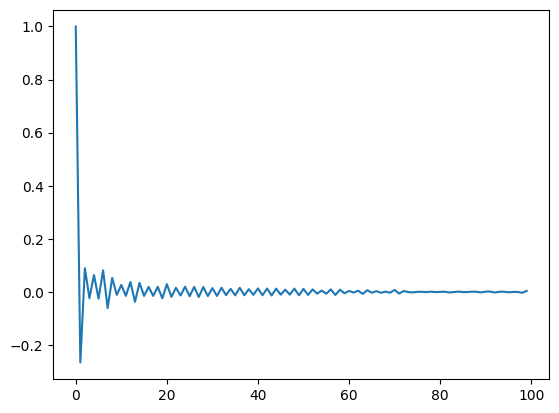

In [418]:
indices, sims, sim_stds = self_similarity(tick_df["price"].diff().iloc[1:], k=100)
plt.plot(indices, sims)
plt.show()

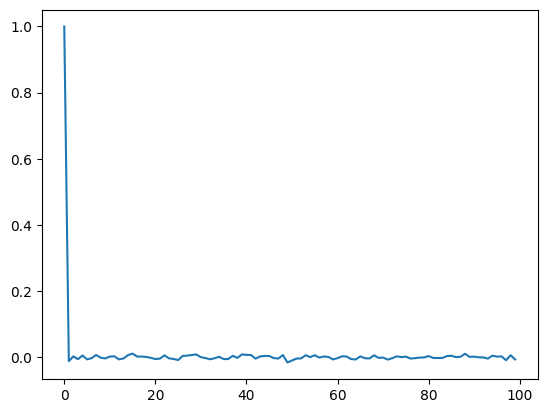

In [423]:
indices, sims, sim_stds = self_similarity(df["close"].diff().iloc[1:], k=100)
plt.plot(indices, sims)
plt.show()

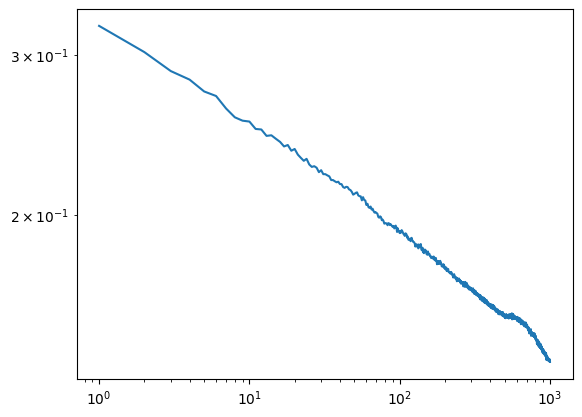

In [434]:
indices, sims, sim_stds = self_similarity(tick_df["price"].diff().abs().iloc[1:], k=1000)

plt.plot(indices[1:], sims[1:])
plt.yscale("log")
plt.xscale("log")
plt.show()

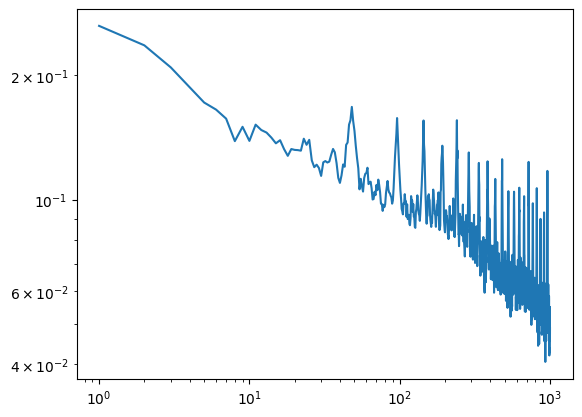

In [443]:
indices, sims, sim_stds = self_similarity(df["close"].diff().abs().iloc[1:], k=1000)

plt.plot(indices[1:], sims[1:])
plt.yscale("log")
plt.xscale("log")
plt.show()

## Transaction time

In [5]:
import datetime

def poisson_pmf(k, lambda_):
    return (np.exp(-lambda_) * lambda_**k) / np.math.factorial(k)

In [ ]:
# remove market holiday
out_condition = 3600 * 24
time_diff = (tick_df.index[1:] - tick_df.index[:-1]).total_seconds()
time_diff = time_diff[time_diff < out_condition]
density, bins_edge = np.histogram(time_diff, density=True, bins=1000)

C:\Users\sato\AppData\Local\Temp\ipykernel_21620\1643651287.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


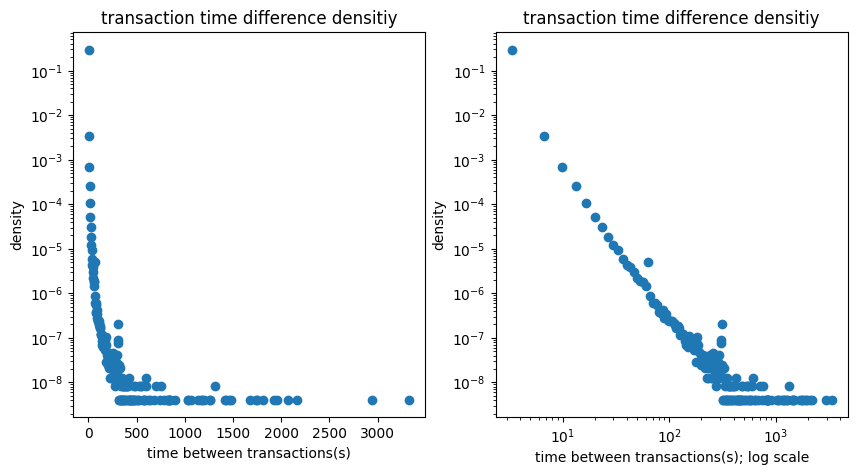

In [157]:
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].scatter(bins_edge[1:], density, marker="o")
axis[0].set_yscale("log")
axis[0].set_title('transaction time difference densitiy')
axis[0].set_xlabel('time between transactions(s)')
axis[0].set_ylabel('density')


axis[1].scatter(bins_edge[1:], density, marker="o")
axis[1].set_yscale("log")
axis[1].set_xscale("log")
axis[1].set_title('transaction time difference densitiy')
axis[1].set_xlabel('time between transactions(s); log scale')
axis[1].set_ylabel('density')
fig.show()

In [72]:
market_open = tick_df.index[1:][(tick_df.index[1:] - tick_df.index[:-1]) >= datetime.timedelta(days=1)]
market_close = tick_df.index[:-1][(tick_df.index[1:] - tick_df.index[:-1]) >= datetime.timedelta(days=1)]

In [76]:
open_datetime = df.index[0]
DFS = []

for index in range(len(market_close)):
    close_datetime = market_close[index]
    day_df = tick_df[(tick_df.index >= open_datetime) & (tick_df.index <= close_datetime)]
    count_df = day_df["price"].groupby(pd.Grouper(level=0, freq="1s")).count()
    DFS.append(count_df)
    open_datetime = market_open[index]

day_df = tick_df[tick_df.index >= open_datetime]
count_df = day_df["price"].groupby(pd.Grouper(level=0, freq="1s")).count()
DFS.append(count_df)
count_df = pd.concat(DFS)    

<Axes: >

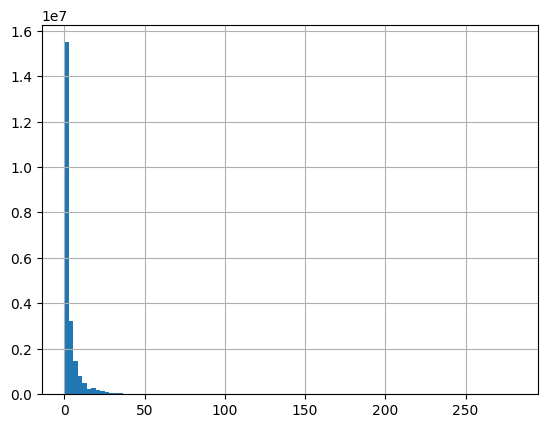

In [91]:
count_df.hist(bins=100)

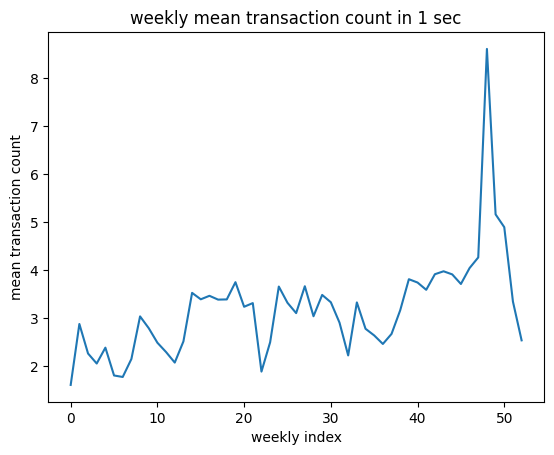

In [101]:
weekly_count_mean = []
for day_df in DFS:
    mean_count = day_df.mean()
    weekly_count_mean.append(mean_count)

plt.plot(weekly_count_mean)
plt.title('weekly mean transaction count in 1 sec')
plt.xlabel('weekly index')
plt.ylabel('mean transaction count')
plt.show()

In [110]:
# mean is not stable and tail is too long
count_df.describe()

count    2.266185e+07
mean     3.228174e+00
std      6.211006e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      2.810000e+02
Name: price, dtype: float64

In [92]:
density, bins_edge = np.histogram(count_df, bins=200, density=True)
mean_count = count_df.mean()

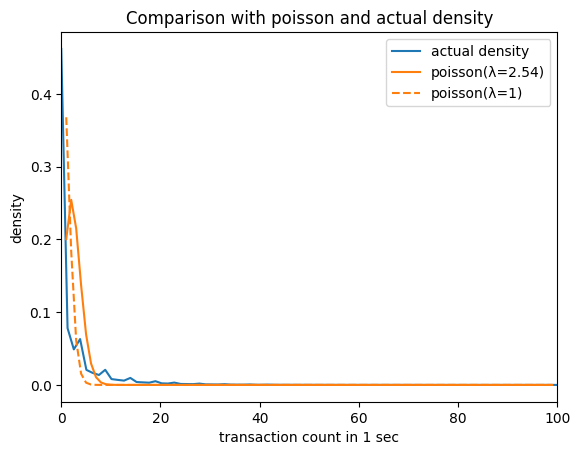

In [109]:
poisson_indices = [*range(1, 100)]
poisson_density = [poisson_pmf(order_count, mean_count) for order_count in poisson_indices]
poisson_density_1 = [poisson_pmf(order_count, 1) for order_count in poisson_indices]
plt.plot(bins_edge[:-1], density, color=colors[0], label="actual density")
plt.plot(poisson_indices, poisson_density, color=colors[1], label=f"poisson(λ={round(mean_count,3)})")
plt.plot(poisson_indices, poisson_density_1, color=colors[1], linestyle="--", label="poisson(λ=1)")
plt.xlim(0, 100)
plt.title('Comparison with poisson and actual density')
plt.xlabel('transaction count in 1 sec')
plt.ylabel('density')
plt.legend()
plt.show()

In [112]:
tick_indexed_df = tick_df.reset_index()
changed_ticks_df = tick_indexed_df[tick_indexed_df["price"].diff() != 0]
steps_to_change = changed_ticks_df.index[1:] - changed_ticks_df.index[:-1]
len(changed_ticks_df)/len(tick_indexed_df)

0.3053314413136023

In [120]:
steps_to_change = pd.Series(steps_to_change)
steps_to_change.describe()

count    2.233694e+07
mean     3.275130e+00
std      5.247257e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.425800e+04
dtype: float64

In [806]:
# traders order with/without value change
density, bin_edges = np.histogram(steps_to_change[steps_to_change <= 30], bins=30, density=True)
adjusted_edges = [round(edge) for edge in bin_edges]
poisson_indices = [*range(1, 31)]
poisson_density = [poisson_pmf(trial, 1) for trial in poisson_indices]

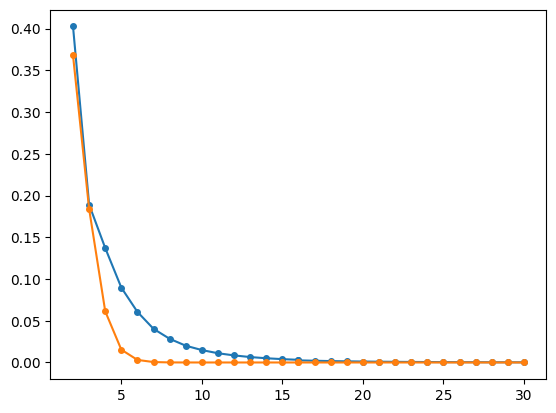

In [807]:
# seems that P(chane) is larger than poisson(λ=1)
plt.plot(adjusted_edges[1:], density, marker="o", markersize=4)
plt.plot(adjusted_edges[1:], poisson_density, marker="o", markersize=4)
plt.show()

## Price diff diffusion

In [100]:
def diffusion(price_srs, n):
    if isinstance(price_srs, pd.Series):
        diff = price_srs.diff(periods=n).dropna()
        return diff.var()
    else:
        diff = (price_srs[:-n] - price_srs[n:])
        p_mean = (diff ** 2).mean()
        mean_p = (diff.mean()) ** 2
        return p_mean - mean_p

In [94]:
steps = [index for index in range(1, 1000)]
variance_diffs = []

np.random.seed(42)
mean = tick_df["price"].diff().mean()
std = tick_df["price"].diff().std()
random_walk = np.cumsum(np.random.normal(size=10000, loc=mean, scale=std))
for step in steps:
    variance_diff = diffusion(random_walk, step)
    variance_diffs.append(variance_diff)
variance_diffs_std = np.sqrt(variance_diffs)

In [101]:
periods = [2**i for i in range(0, 11)]
var_diffusions = np.array([diffusion(tick_df["price"], period) for period in periods])
std_diffusions = np.sqrt(var_diffusions)

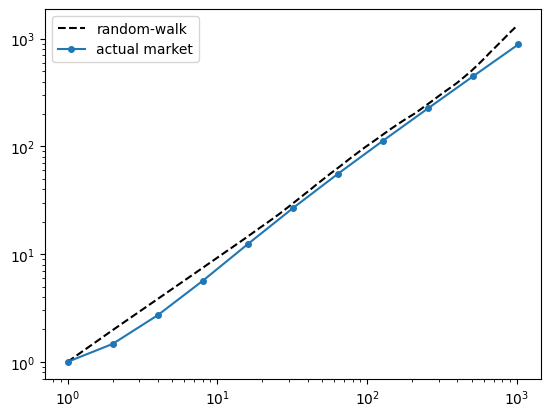

In [106]:
# typically finance data indicate strictly lower diffusion on small periods. larger periods indicate similar with random walk
plt.plot(steps, variance_diffs/variance_diffs[0], label="random-walk", color="black", linestyle="--")
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market", color=colors[0], linestyle="-", marker="o", markersize=4)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

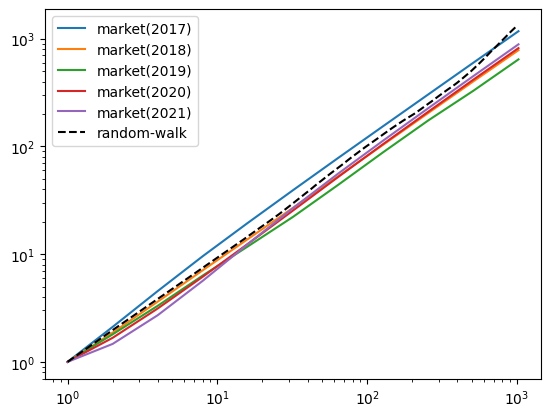

In [107]:
years = [2017, 2018, 2019, 2020, 2021]
yearly_diffusions = []
for index, year in enumerate(years):
    files = search_tick_files(sub_folder="OANDA-Japan TicksDL", pair="USDJPY", year=year)
    yaer_tick_df = merge_ticks(files)
    diffusions = np.array([diffusion(yaer_tick_df["price"], step) for step in periods])
    plt.plot(periods, diffusions/diffusions[0], label=f"market({year})", color=colors[index])
    yearly_diffusions.append(diffusions)
plt.plot(steps, variance_diffs/variance_diffs[0], label="random-walk", color="black", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [108]:
# check if it is the same with time frame index
steps = [index for index in range(1, 1000)]
variance_diffs = []

np.random.seed(42)
mean = df["close"].diff().mean()
std = df["close"].diff().std()
random_walk = np.cumsum(np.random.normal(size=10000, loc=mean, scale=std))
for step in steps:
    variance_diff = diffusion(random_walk, step)
    variance_diffs.append(variance_diff)
variance_diffs_std = np.sqrt(variance_diffs)

In [109]:
periods = [2**i for i in range(0, 11)]
var_diffusions = np.array([diffusion(df["close"], period) for period in periods])
std_diffusions = np.sqrt(var_diffusions)

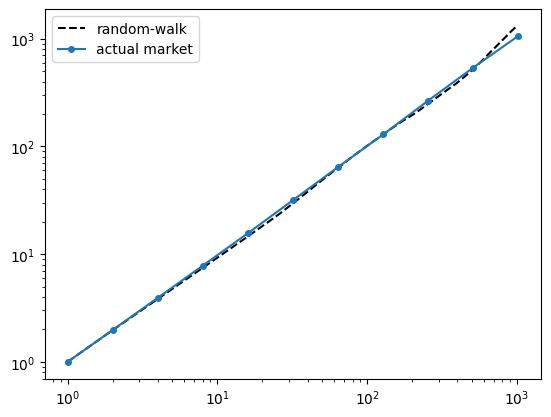

In [110]:
# 30 min indicate the same as random walk. need to check other time frame.
plt.plot(steps, variance_diffs/variance_diffs[0], label="random-walk", color="black", linestyle="--")
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market", color=colors[0], linestyle="-", marker="o", markersize=4)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()